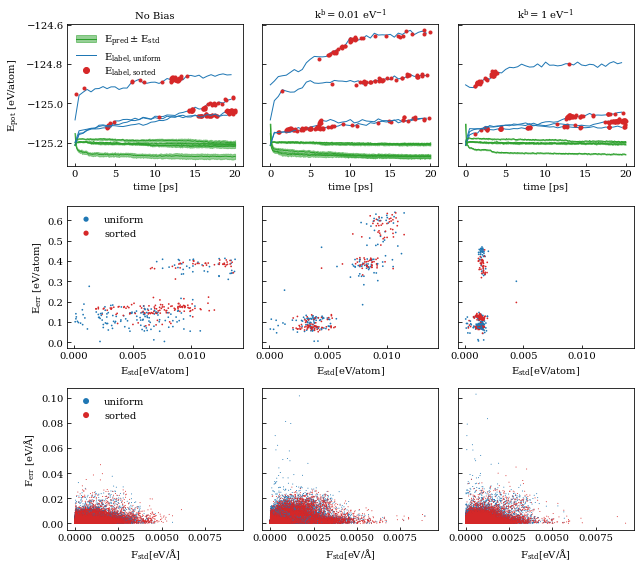

In [113]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tips.io import load_ds

def plot_energies(ax, ds, color):
    e_bias = np.array([d['energy_bias'] for d in ds])/640
    e_avg = np.array([d['energy_avg'] for d in ds])/640
    e_std = np.array([d['energy_std'] for d in ds])/640
    t = np.arange(len(e_std))/10.
    l1 = ax.fill_between(t, e_avg-e_std, e_avg+e_std, color=color, alpha=0.5)
    l2, = ax.plot(t, e_avg, color=color, lw=1)
    # l3 = ax.plot(t, e_avg+e_bias, 'k:', lw=1)
    return (l1,l2) #, l3

    
f, axs = plt.subplots(3,3, figsize=[9,8], sharey='row', sharex='row')
for name, (ax1, ax2, ax3), title in zip(
    [
        'pils-v5-ekf-v3-gen0-nobias', 
        'pils-v5-ekf-v3-gen0-bias001',
        'pils-v5-ekf-v3-gen0-bias1'
    ], 
    axs.T, 
    ['No Bias', '$k^b=0.01~eV^{-1}$', '$k^b=1~eV^{-1}$']
):
    for ftraj in glob(f'../trajs/emd/{name}/*/asemd.traj')[:4]:
        init = Path(ftraj).parent.name
        traj = load_ds(ftraj, fmt='asetraj', index='::10')
        l1 = [plot_energies(ax1, traj, 'tab:green')]
        l2 = []
        l3 = []
        for strategy, sname, color, style, label in zip(
            ['uniform','sorted'], ['uniform', 'forces'], ['tab:blue','tab:red'], ['-','o'], ['uniform', 'max forces']):
            idx1, ds1 = traj.subsample(strategy, 40)
            logs = glob(f'../trajs/cpsp/{name}/{init}/{sname}/*/cp2k.log')
            idx2 =  np.array([int(Path(l).parent.name) for l in logs])
            sort = np.argsort(idx2)
            e_model = np.array([d['energy_avg'] for d in ds1])/640
            e_label = np.array([load_ds(l, fmt='cp2klog')[0]['energy']*27.2114 for l in logs])/640
            e_std = np.array([d['energy_std'] for d in ds1])/640
            
            f_model = np.array([d['force_avg'] for d in ds1])/640
            f_label = np.array([load_ds(l, fmt='cp2klog')[0]['force']*27.2114 for l in logs])/640
            f_std = np.array([d['force_std'] for d in ds1])/640
            
            l1.append(ax1.plot(idx2[sort]/100., e_label[sort], style, ms=3, lw=1, color=color)[0])
            l2.append(ax2.scatter(e_std, np.abs(e_model-e_label), s=3, ec=None, color=color, label=label))
            l3.append(ax3.scatter(f_std, np.abs(f_model-f_label), s=1, ec=None, color=color, label=label))
       
    ax1.set_xlabel('time [ps]')
    ax1.set_title(title, fontsize=10)
    ax2.set_xlabel('$E_{std} [eV/atom]$')
    ax3.set_xlabel('$F_{std} [eV/\AA]$')
    
axs[0,0].set_ylabel('$E_{pot}~[eV/atom]$')
axs[1,0].set_ylabel('$E_{err}~[eV/atom]$')
axs[2,0].set_ylabel('$F_{err}~[eV/\AA]$')

axs[0,0].legend(l1, ['$E_{pred} \pm E_{std}$', '$E_{label,uniform}$', '$E_{label,sorted}$'], labelspacing=0.2, markerscale=2)
axs[1,0].legend(l2, ['uniform', 'sorted'], markerscale=3, loc=2)
axs[2,0].legend(l3, ['uniform', 'sorted'], markerscale=6, loc=2)
plt.tight_layout()
plt.savefig('test.png')

In [ ]:
e_std.shape

In [ ]:
# some normal conversion for visualization

from ase.io import read, write
traj = read('../trajs/ase/nvt-300k-100ps/pils-v5-filtered-pinet-adam-v2-pre-hoac-c1im-a32b32i0-rho1.0753/asemd.traj', index='::10')
write('adam-m32-r1.0-100ps.xyz', traj)
traj = read('../trajs//ase/nvt-300k-100ps/pils-v5-filtered-pinet-ekf-v3-pre-hoac-c1im-a32b32i0-rho1.0753/asemd.traj', index='::10')
write('ekf-m32-r1.0-100ps.xyz', traj)